# USOD Technical Paper - Comprehensive ML Model Training

This notebook trains multiple machine learning models on the CICIDS2017 dataset for the USOD technical paper.

**Models Trained:**
1. Random Forest
2. Extra Trees
3. XGBoost
4. LightGBM
5. CatBoost
6. Isolation Forest (Anomaly Detection)

**Output:**
- Confusion matrices for each model
- ROC curves comparison
- Feature importance plots
- Performance metrics table

---
## 1. Setup and Imports

In [1]:
# Install required packages if needed
# !pip install xgboost lightgbm catboost scikit-learn pandas matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc
)
import joblib

# Boosting libraries
try:
    from xgboost import XGBClassifier
    print("✅ XGBoost imported")
except ImportError:
    print("❌ XGBoost not installed. Run: pip install xgboost")
    XGBClassifier = None

try:
    from lightgbm import LGBMClassifier
    print("✅ LightGBM imported")
except ImportError:
    print("❌ LightGBM not installed. Run: pip install lightgbm")
    LGBMClassifier = None

try:
    from catboost import CatBoostClassifier
    print("✅ CatBoost imported")
except ImportError:
    print("❌ CatBoost not installed. Run: pip install catboost")
    CatBoostClassifier = None

# Set style for paper-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

print("\n✅ All core libraries imported successfully")

✅ XGBoost imported
✅ LightGBM imported
✅ CatBoost imported

✅ All core libraries imported successfully


In [3]:
# Create output directory
OUTPUT_DIR = Path("paper_results")
OUTPUT_DIR.mkdir(exist_ok=True)

MODEL_DIR = OUTPUT_DIR / "models"
MODEL_DIR.mkdir(exist_ok=True)

print(f"📁 Results will be saved to: {OUTPUT_DIR.absolute()}")

📁 Results will be saved to: C:\Users\Ghulam Mohayudin\Projects\Others\usod\ai\paper_results


---
## 2. Load CICIDS2017 Dataset (All CSVs Once)

In [4]:
# Dataset path
DATA_DIR = Path("data/raw")

# List all CSV files
csv_files = list(DATA_DIR.glob("*.csv"))
print(f"Found {len(csv_files)} CSV files:")
total_size = 0
for f in csv_files:
    size_mb = f.stat().st_size / (1024 * 1024)
    total_size += size_mb
    print(f"  📄 {f.name}: {size_mb:.1f} MB")
print(f"\n📊 Total: {total_size:.1f} MB")

Found 8 CSV files:
  📄 Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv: 73.6 MB
  📄 Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv: 73.3 MB
  📄 Friday-WorkingHours-Morning.pcap_ISCX.csv: 55.6 MB
  📄 Monday-WorkingHours.pcap_ISCX.csv: 168.7 MB
  📄 Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv: 79.3 MB
  📄 Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv: 49.6 MB
  📄 Tuesday-WorkingHours.pcap_ISCX.csv: 128.8 MB
  📄 Wednesday-workingHours.pcap_ISCX.csv: 214.7 MB

📊 Total: 843.7 MB


In [5]:
# Load all files and combine - THIS RUNS ONCE
print("Loading all CSV files... (this may take a few minutes)")
start_time = time.time()

dfs = []
for csv_file in csv_files:
    print(f"  Loading {csv_file.name}...", end=" ")
    try:
        df = pd.read_csv(csv_file, encoding='utf-8', low_memory=False)
        df.columns = df.columns.str.strip()  # Clean column names
        dfs.append(df)
        print(f"✅ {len(df):,} rows")
    except Exception as e:
        print(f"❌ Error: {e}")

# Combine all dataframes
data = pd.concat(dfs, ignore_index=True)
load_time = time.time() - start_time

print(f"\n✅ Dataset loaded in {load_time:.1f} seconds")
print(f"📊 Total: {len(data):,} rows, {len(data.columns)} columns")

Loading all CSV files... (this may take a few minutes)
  Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv... ✅ 225,745 rows
  Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv... ✅ 286,467 rows
  Loading Friday-WorkingHours-Morning.pcap_ISCX.csv... ✅ 191,033 rows
  Loading Monday-WorkingHours.pcap_ISCX.csv... ✅ 529,918 rows
  Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv... ✅ 288,602 rows
  Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv... ✅ 170,366 rows
  Loading Tuesday-WorkingHours.pcap_ISCX.csv... ✅ 445,909 rows
  Loading Wednesday-workingHours.pcap_ISCX.csv... ✅ 692,703 rows

✅ Dataset loaded in 20.5 seconds
📊 Total: 2,830,743 rows, 79 columns


In [6]:
# Preview data
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


---
## 3. Data Exploration

In [7]:
# Label distribution
print("📊 Attack Type Distribution:")
label_counts = data['Label'].value_counts()
print(label_counts)
print(f"\nTotal classes: {len(label_counts)}")

📊 Attack Type Distribution:
Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

Total classes: 15


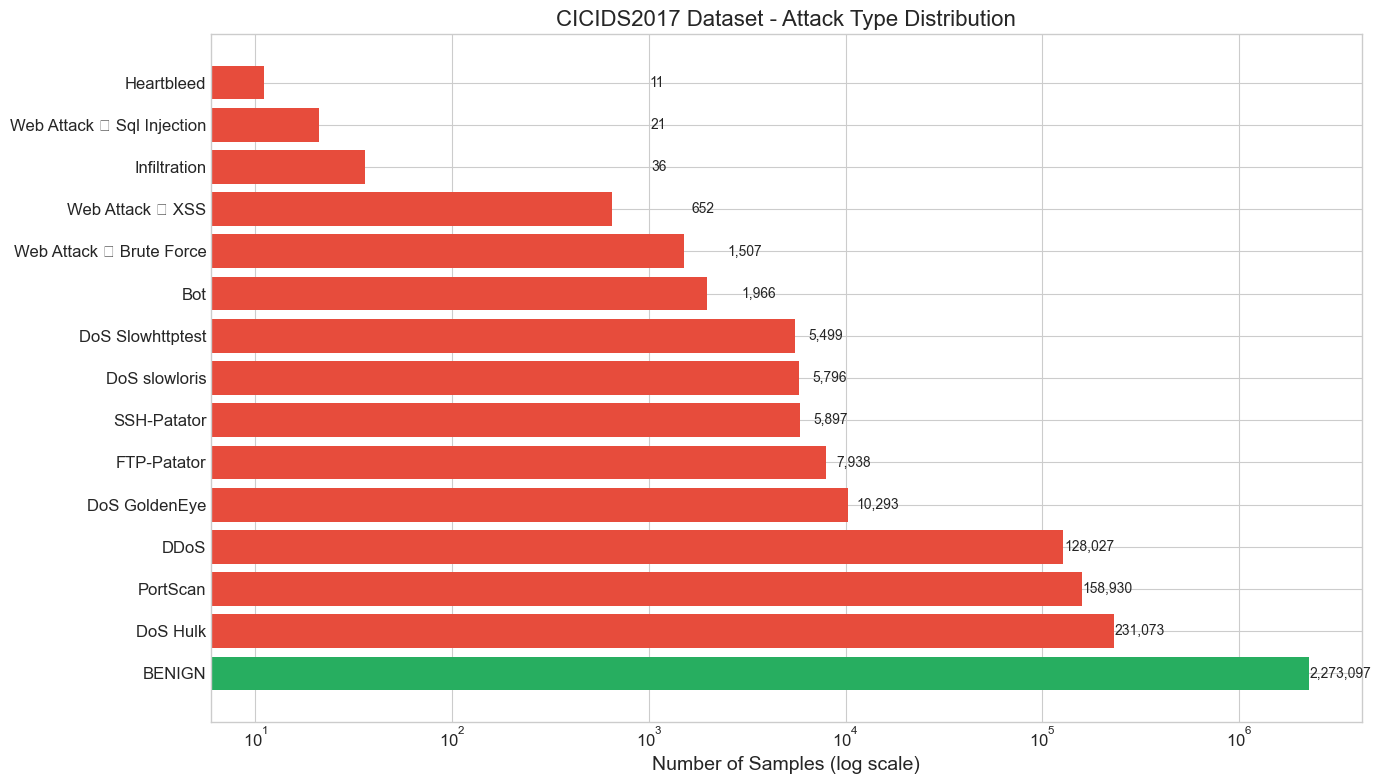

✅ Saved: dataset_attack_distribution.png


In [8]:
# Visualize attack distribution
plt.figure(figsize=(14, 8))
colors = ['#27ae60' if 'BENIGN' in label else '#e74c3c' for label in label_counts.index]
bars = plt.barh(label_counts.index, label_counts.values, color=colors)

# Add value labels
for bar, value in zip(bars, label_counts.values):
    plt.text(value + 1000, bar.get_y() + bar.get_height()/2, 
             f'{value:,}', va='center', fontsize=10)

plt.xlabel('Number of Samples (log scale)')
plt.xscale('log')
plt.title('CICIDS2017 Dataset - Attack Type Distribution')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dataset_attack_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: dataset_attack_distribution.png")

---
## 4. Data Preprocessing

In [9]:
# Clean data
print(f"Before cleaning: {len(data):,} rows")

# Replace infinity values
data = data.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN
data = data.dropna()

print(f"After cleaning: {len(data):,} rows")

Before cleaning: 2,830,743 rows
After cleaning: 2,827,876 rows


In [10]:
# Separate features and labels
X = data.drop(columns=['Label'])
y = data['Label']

# Keep only numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numeric_cols]

print(f"Features: {len(numeric_cols)} numeric columns")
print(f"Samples: {len(X):,}")

Features: 78 numeric columns
Samples: 2,827,876


In [11]:
# Encode labels for multiclass
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

print(f"Classes ({len(class_names)}): {list(class_names)}")

Classes (15): ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']


In [12]:
# Create binary labels (BENIGN=0, ATTACK=1)
y_binary = np.where(y == 'BENIGN', 0, 1)

print(f"Binary distribution:")
print(f"  BENIGN (0): {np.sum(y_binary == 0):,}")
print(f"  ATTACK (1): {np.sum(y_binary == 1):,}")

Binary distribution:
  BENIGN (0): 2,271,320
  ATTACK (1): 556,556


In [13]:
# Sample for faster training - ADJUST THIS VALUE
SAMPLE_SIZE = 300000  # Increase for better results, decrease for faster training

if len(X) > SAMPLE_SIZE:
    print(f"⚡ Sampling {SAMPLE_SIZE:,} rows for training (stratified)...")
    X_sampled, _, y_multi_sampled, _, y_bin_sampled, _ = train_test_split(
        X, y_encoded, y_binary,
        train_size=SAMPLE_SIZE,
        stratify=y_encoded,
        random_state=42
    )
    X_sampled = X_sampled.values
else:
    X_sampled = X.values
    y_multi_sampled = y_encoded
    y_bin_sampled = y_binary

print(f"Training set size: {len(X_sampled):,}")

⚡ Sampling 300,000 rows for training (stratified)...
Training set size: 300,000


In [14]:
# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sampled)
print("✅ Features scaled")

Scaling features...
✅ Features scaled


In [25]:
# Filter out classes with too few samples for stratified split
min_samples_per_class = 10  # Need at least this many for train/test split

# Count samples per class
unique, counts = np.unique(y_multi_sampled, return_counts=True)
valid_classes = unique[counts >= min_samples_per_class]

# Create mask for valid samples
valid_mask = np.isin(y_multi_sampled, valid_classes)

print(f"Filtered out {len(unique) - len(valid_classes)} rare classes")
print(f"Samples after filtering: {np.sum(valid_mask):,}")

# Apply filter
X_filtered = X_scaled[valid_mask]
y_multi_filtered = y_multi_sampled[valid_mask]
y_bin_filtered = y_bin_sampled[valid_mask]

# RE-ENCODE LABELS TO BE SEQUENTIAL (0, 1, 2, ...)
# This is required for XGBoost
from sklearn.preprocessing import LabelEncoder
reencoder = LabelEncoder()
y_multi_filtered = reencoder.fit_transform(y_multi_filtered)

# Update class_names to match the filtered classes
class_names = label_encoder.classes_[valid_classes]
print(f"Remaining classes ({len(class_names)}): {list(class_names)}")

# Train/Test split - MULTICLASS
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_multi_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_multi_filtered
)

# Train/Test split - BINARY  
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_filtered, y_bin_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_bin_filtered
)

print(f"Train set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

Filtered out 3 rare classes
Samples after filtering: 299,993
Remaining classes (12): ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'PortScan', 'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � XSS']
Train set: 239,994 samples
Test set: 59,999 samples


---
## 5. Helper Functions

In [26]:
# Dictionary to store all results
results = {}

def evaluate_model(model, X_test, y_test, model_name, is_binary=False):
    """Evaluate model and store results"""
    y_pred = model.predict(X_test)
    
    if is_binary:
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    else:
        y_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'predictions': y_pred,
        'probabilities': y_proba
    }
    
    results[model_name] = metrics
    
    print(f"\n{'='*50}")
    print(f"{model_name} RESULTS")
    print(f"{'='*50}")
    print(f"Accuracy:  {metrics['accuracy']*100:.2f}%")
    print(f"Precision: {metrics['precision']*100:.2f}%")
    print(f"Recall:    {metrics['recall']*100:.2f}%")
    print(f"F1-Score:  {metrics['f1']*100:.2f}%")
    
    return metrics

def plot_confusion_matrix(y_true, y_pred, class_labels, model_name, filename):
    """Plot and save confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    acc = accuracy_score(y_true, y_pred)
    plt.title(f'{model_name} Confusion Matrix (Accuracy: {acc*100:.2f}%)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {filename}")

def plot_feature_importance(model, feature_names, model_name, filename, top_n=15):
    """Plot feature importance"""
    if hasattr(model, 'feature_importances_'):
        importance = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 8))
        colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(importance)))[::-1]
        plt.barh(importance['feature'], importance['importance'], color=colors)
        plt.xlabel('Importance')
        plt.title(f'{model_name} - Top {top_n} Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✅ Saved: {filename}")
        return importance
    else:
        print(f"⚠️ {model_name} does not have feature_importances_")
        return None

---
## 6. Model 1: Random Forest

In [27]:
print("🌲 Training Random Forest...")
start = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train, y_train)

train_time = time.time() - start
print(f"✅ Random Forest trained in {train_time:.1f}s")

# Evaluate
rf_metrics = evaluate_model(rf_model, X_test, y_test, 'Random Forest')

🌲 Training Random Forest...
✅ Random Forest trained in 23.6s

Random Forest RESULTS
Accuracy:  99.82%
Precision: 99.80%
Recall:    99.82%
F1-Score:  99.81%


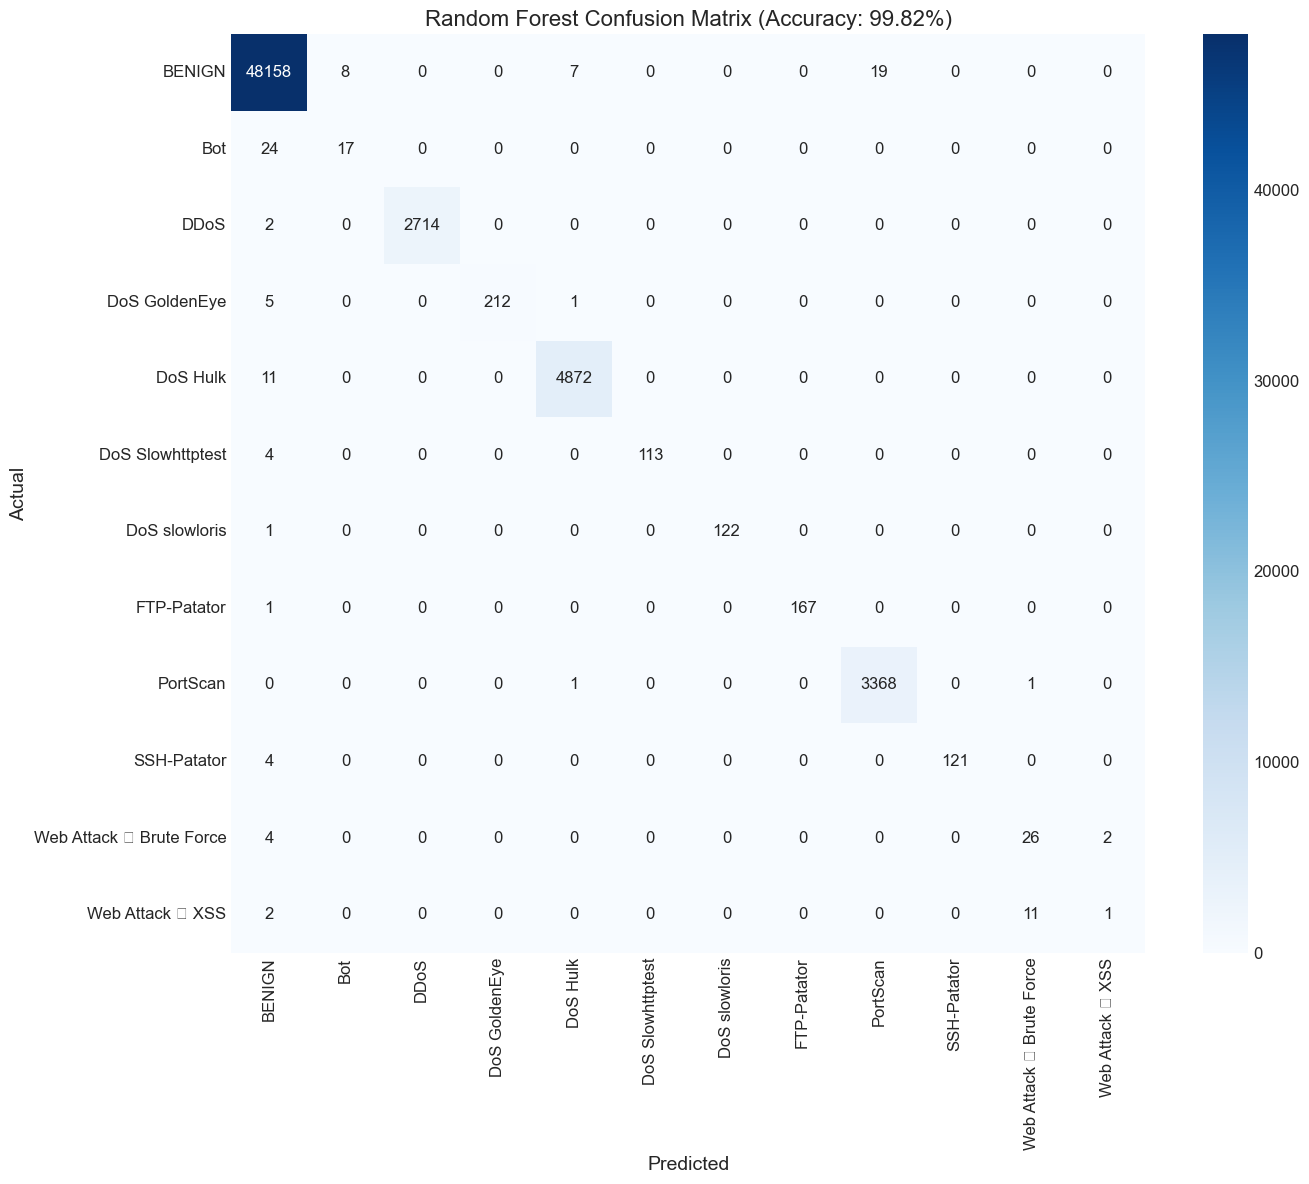

✅ Saved: rf_confusion_matrix.png


In [28]:
# Random Forest Confusion Matrix
plot_confusion_matrix(y_test, rf_metrics['predictions'], class_names, 
                      'Random Forest', 'rf_confusion_matrix.png')

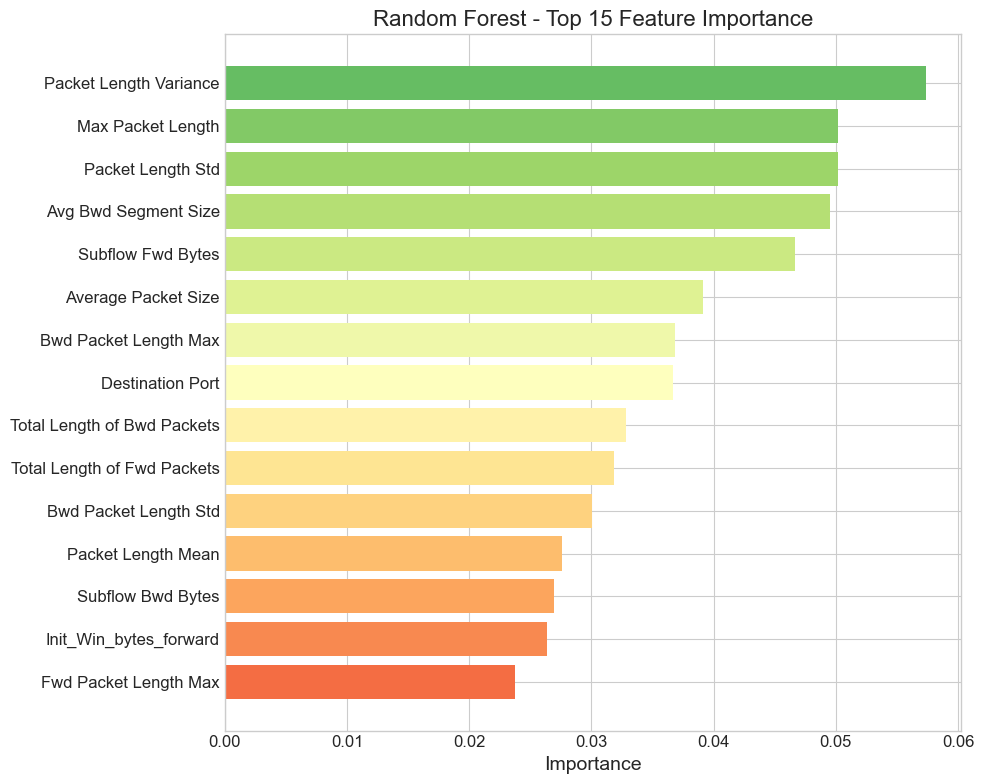

✅ Saved: rf_feature_importance.png


In [29]:
# Random Forest Feature Importance
rf_importance = plot_feature_importance(rf_model, numeric_cols, 
                                        'Random Forest', 'rf_feature_importance.png')

---
## 7. Model 2: Extra Trees

In [30]:
print("🌳 Training Extra Trees...")
start = time.time()

et_model = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
et_model.fit(X_train, y_train)

train_time = time.time() - start
print(f"✅ Extra Trees trained in {train_time:.1f}s")

# Evaluate
et_metrics = evaluate_model(et_model, X_test, y_test, 'Extra Trees')

🌳 Training Extra Trees...
✅ Extra Trees trained in 14.3s

Extra Trees RESULTS
Accuracy:  99.13%
Precision: 99.11%
Recall:    99.13%
F1-Score:  99.06%


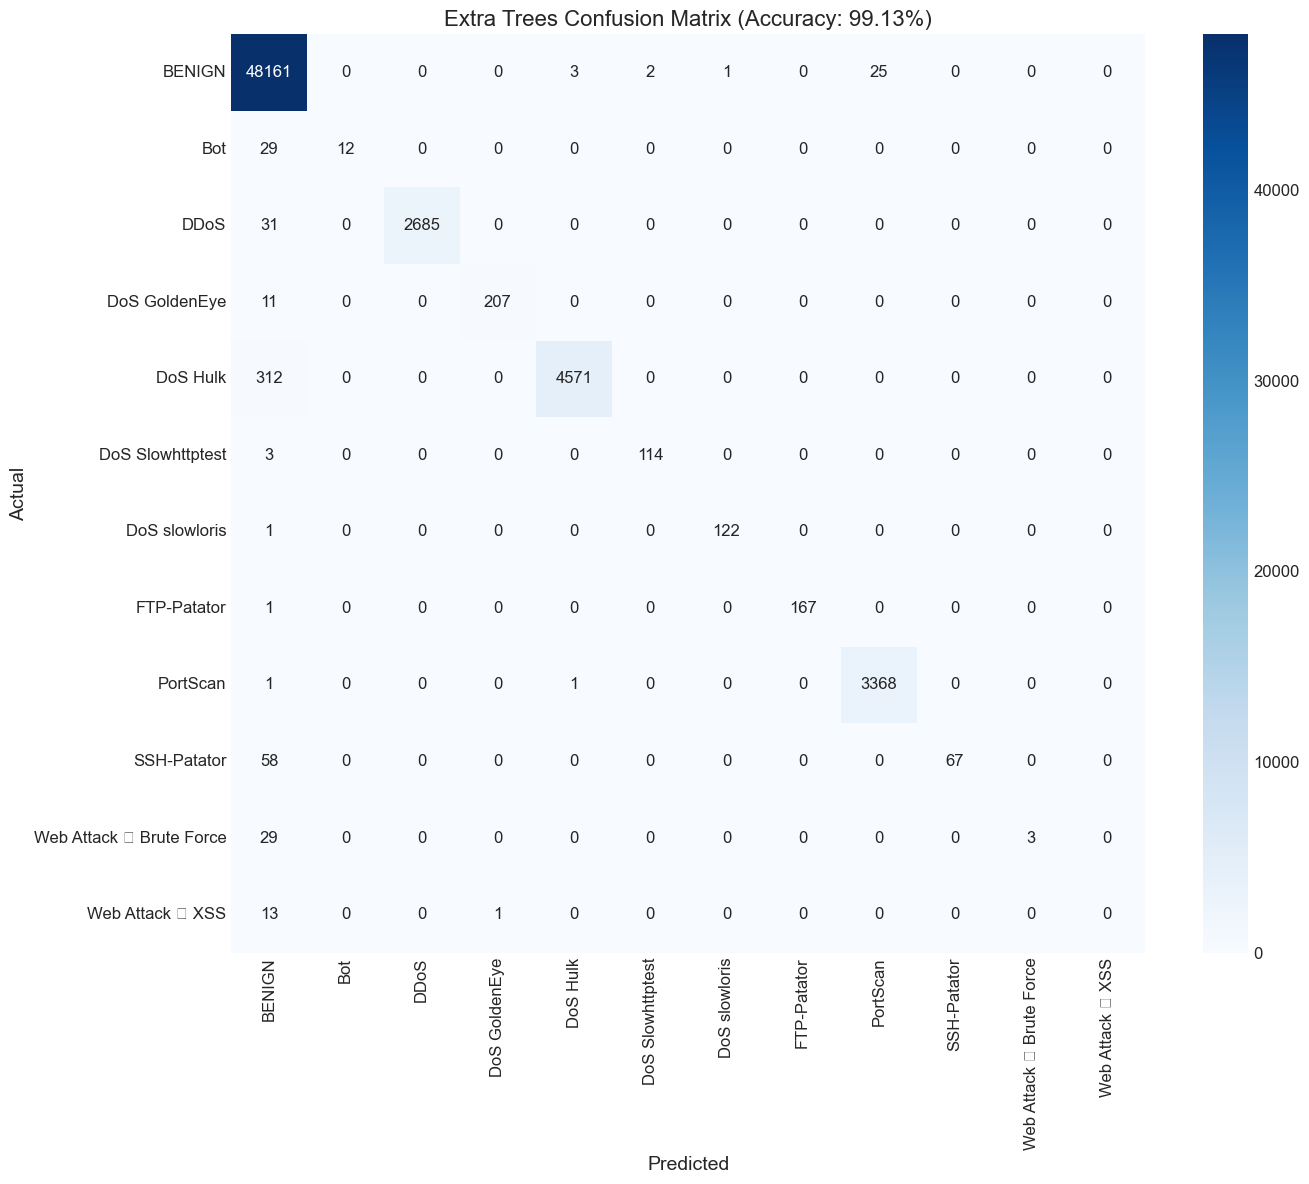

✅ Saved: et_confusion_matrix.png


In [31]:
# Extra Trees Confusion Matrix
plot_confusion_matrix(y_test, et_metrics['predictions'], class_names,
                      'Extra Trees', 'et_confusion_matrix.png')

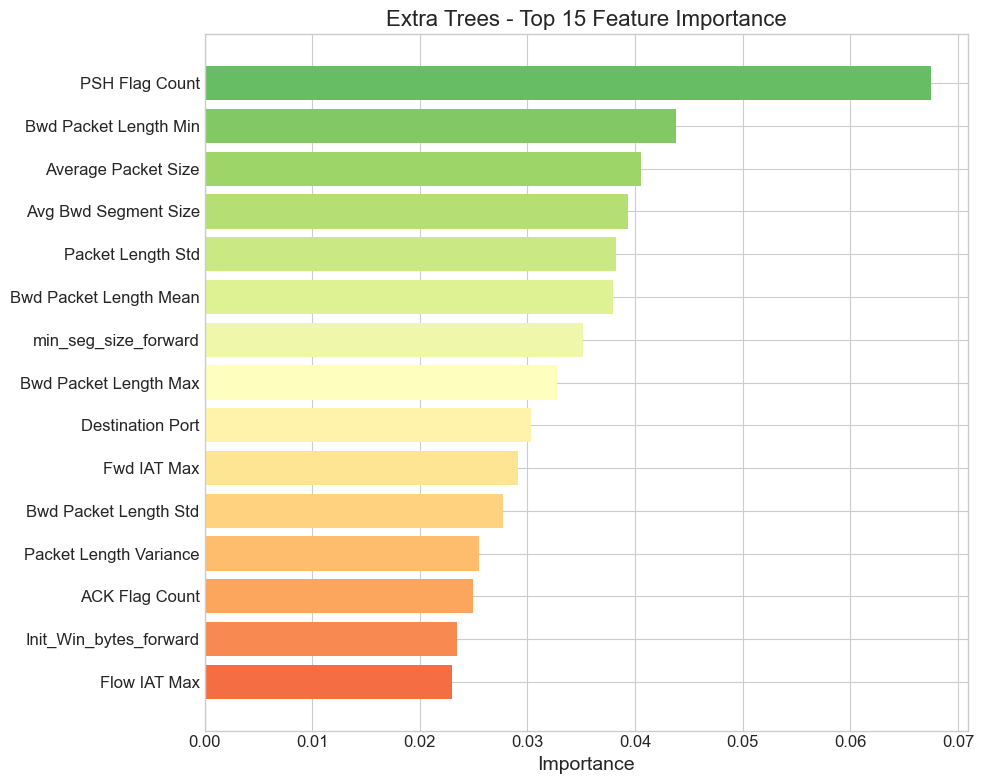

✅ Saved: et_feature_importance.png


In [32]:
# Extra Trees Feature Importance
et_importance = plot_feature_importance(et_model, numeric_cols,
                                        'Extra Trees', 'et_feature_importance.png')

---
## 8. Model 3: XGBoost

In [33]:
if XGBClassifier is not None:
    print("🚀 Training XGBoost...")
    start = time.time()
    
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train)
    
    train_time = time.time() - start
    print(f"✅ XGBoost trained in {train_time:.1f}s")
    
    # Evaluate
    xgb_metrics = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')
else:
    print("⚠️ XGBoost not available. Install with: pip install xgboost")

🚀 Training XGBoost...
✅ XGBoost trained in 25.2s

XGBoost RESULTS
Accuracy:  99.88%
Precision: 99.88%
Recall:    99.88%
F1-Score:  99.88%


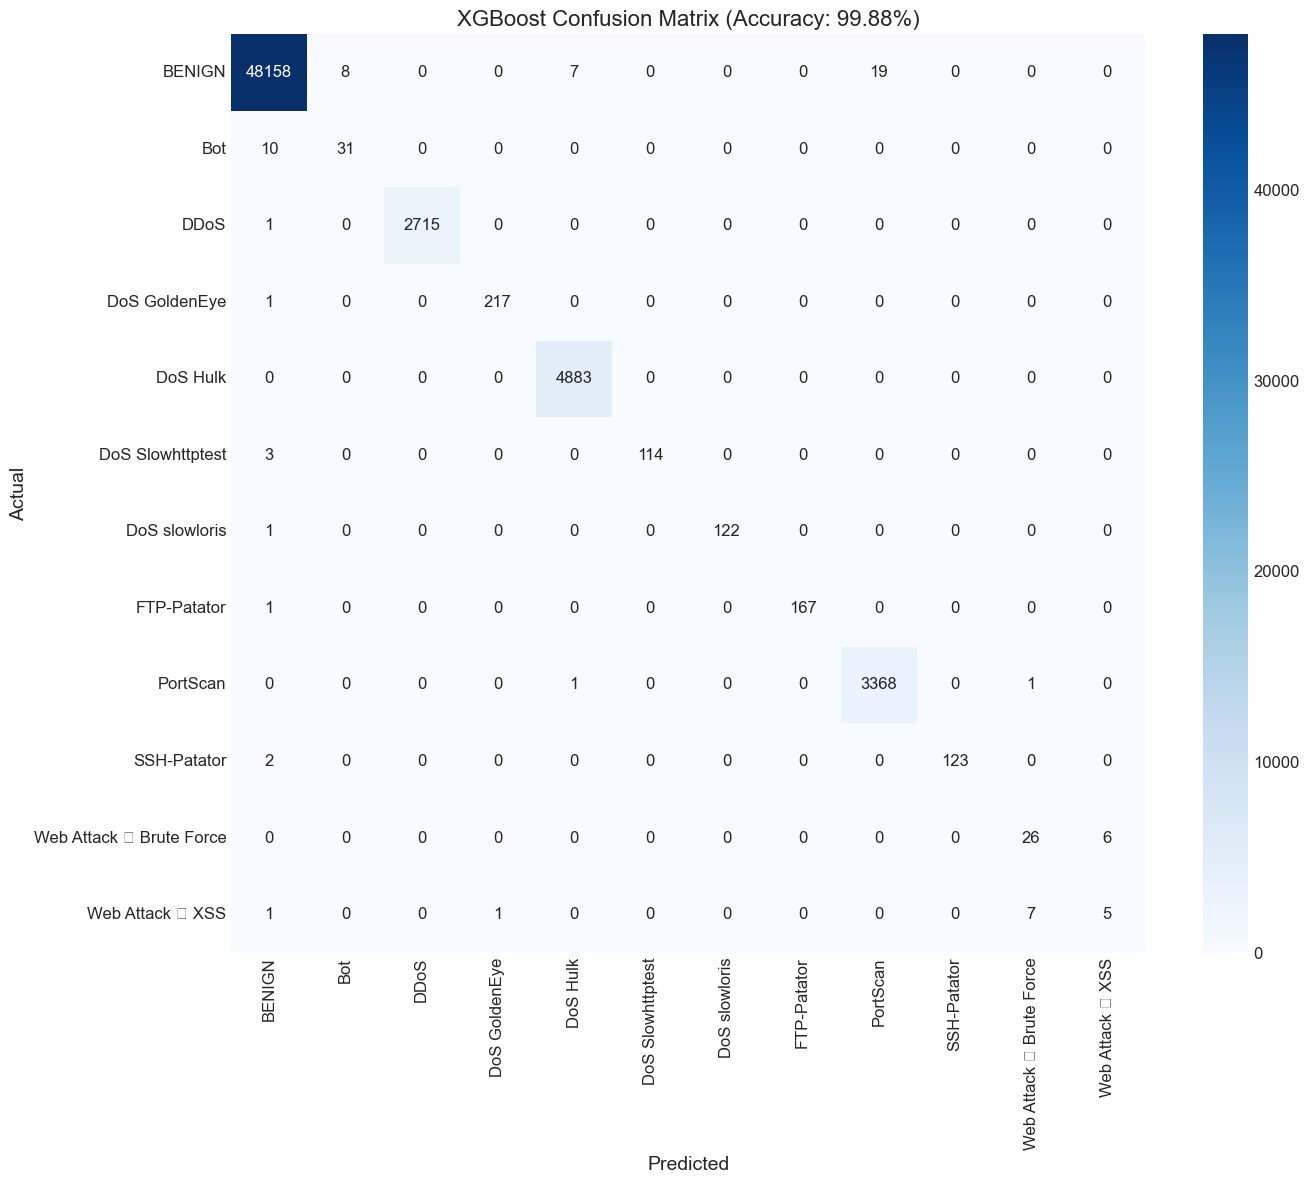

✅ Saved: xgb_confusion_matrix.png


In [34]:
if XGBClassifier is not None:
    # XGBoost Confusion Matrix
    plot_confusion_matrix(y_test, xgb_metrics['predictions'], class_names,
                          'XGBoost', 'xgb_confusion_matrix.png')

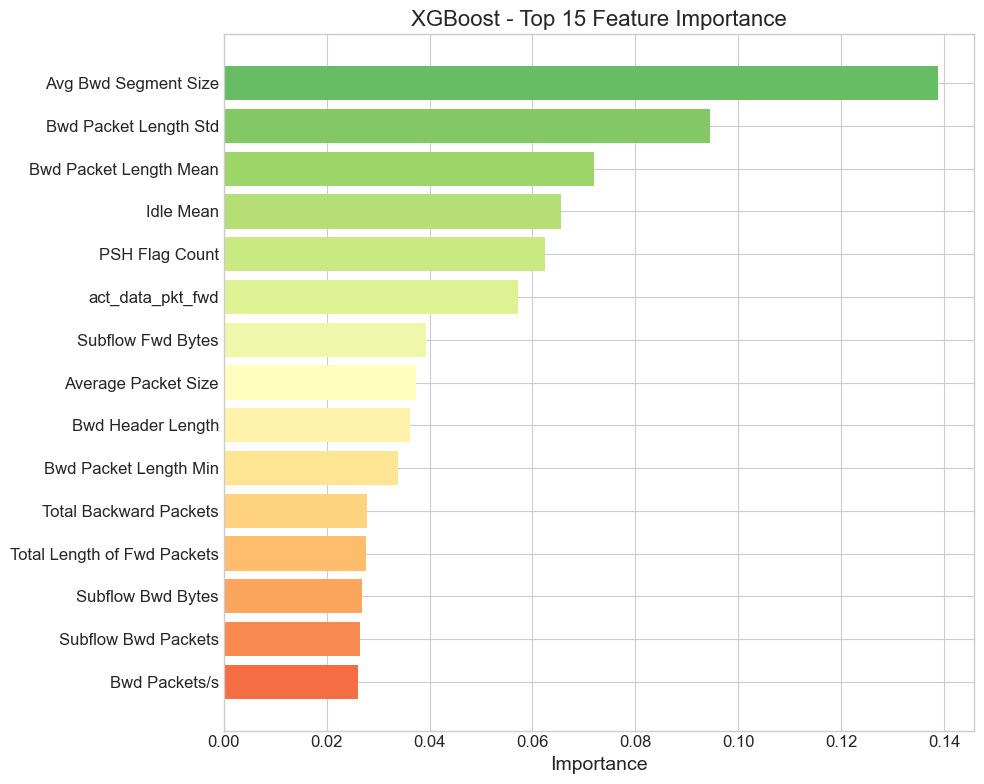

✅ Saved: xgb_feature_importance.png


In [35]:
if XGBClassifier is not None:
    # XGBoost Feature Importance
    xgb_importance = plot_feature_importance(xgb_model, numeric_cols,
                                             'XGBoost', 'xgb_feature_importance.png')

---
## 9. Model 4: LightGBM

In [36]:
if LGBMClassifier is not None:
    print("💡 Training LightGBM...")
    start = time.time()
    
    lgbm_model = LGBMClassifier(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42,
        verbose=-1
    )
    lgbm_model.fit(X_train, y_train)
    
    train_time = time.time() - start
    print(f"✅ LightGBM trained in {train_time:.1f}s")
    
    # Evaluate
    lgbm_metrics = evaluate_model(lgbm_model, X_test, y_test, 'LightGBM')
else:
    print("⚠️ LightGBM not available. Install with: pip install lightgbm")

💡 Training LightGBM...
✅ LightGBM trained in 12.5s

LightGBM RESULTS
Accuracy:  81.36%
Precision: 89.18%
Recall:    81.36%
F1-Score:  83.67%


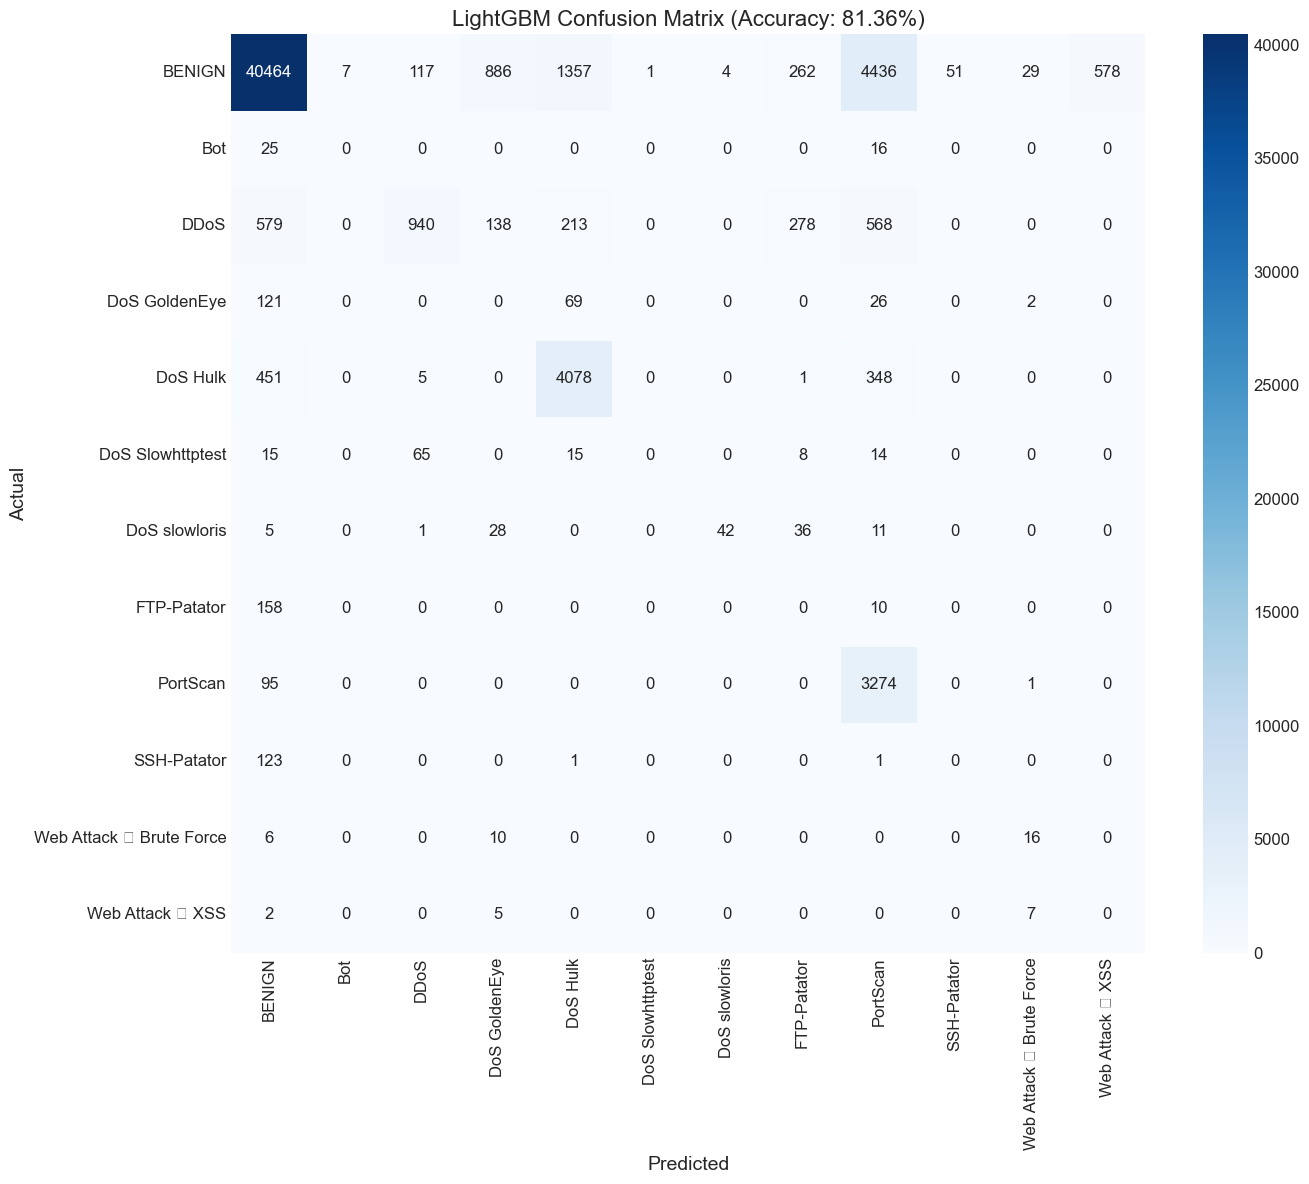

✅ Saved: lgbm_confusion_matrix.png


In [37]:
if LGBMClassifier is not None:
    # LightGBM Confusion Matrix
    plot_confusion_matrix(y_test, lgbm_metrics['predictions'], class_names,
                          'LightGBM', 'lgbm_confusion_matrix.png')

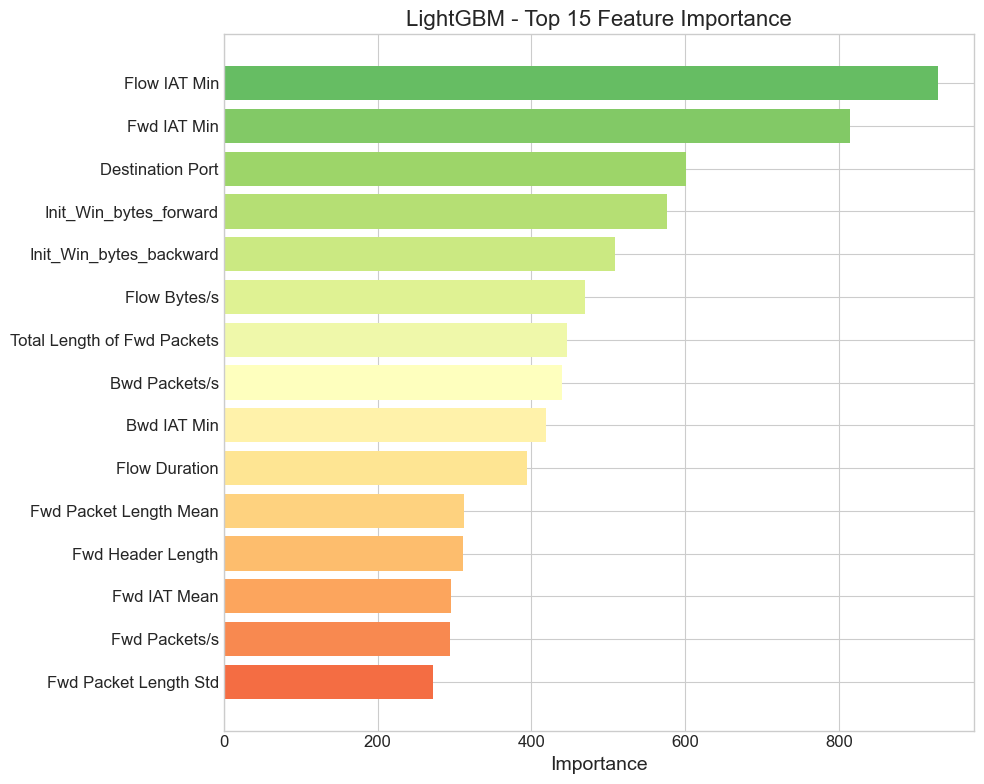

✅ Saved: lgbm_feature_importance.png


In [38]:
if LGBMClassifier is not None:
    # LightGBM Feature Importance
    lgbm_importance = plot_feature_importance(lgbm_model, numeric_cols,
                                              'LightGBM', 'lgbm_feature_importance.png')

---
## 10. Model 5: CatBoost

In [39]:
if CatBoostClassifier is not None:
    print("🐱 Training CatBoost...")
    start = time.time()
    
    catboost_model = CatBoostClassifier(
        iterations=100,
        depth=10,
        learning_rate=0.1,
        random_state=42,
        verbose=False
    )
    catboost_model.fit(X_train, y_train)
    
    train_time = time.time() - start
    print(f"✅ CatBoost trained in {train_time:.1f}s")
    
    # Evaluate
    catboost_metrics = evaluate_model(catboost_model, X_test, y_test, 'CatBoost')
else:
    print("⚠️ CatBoost not available. Install with: pip install catboost")

🐱 Training CatBoost...
✅ CatBoost trained in 285.7s

CatBoost RESULTS
Accuracy:  99.81%
Precision: 99.79%
Recall:    99.81%
F1-Score:  99.79%


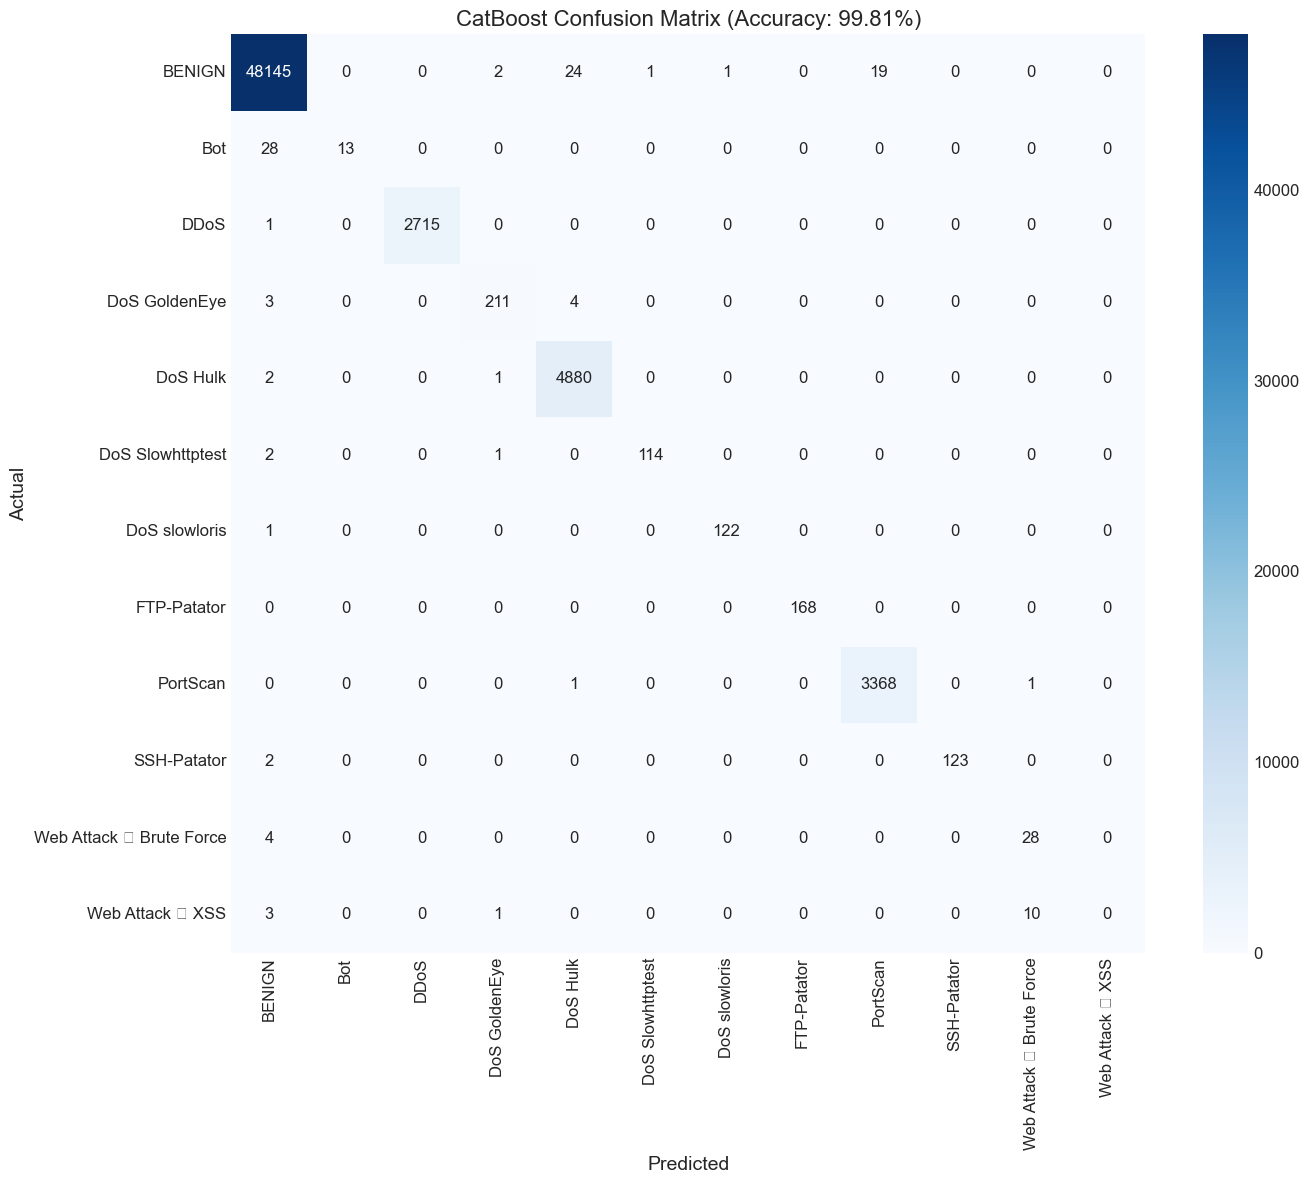

✅ Saved: catboost_confusion_matrix.png


In [40]:
if CatBoostClassifier is not None:
    # CatBoost Confusion Matrix
    plot_confusion_matrix(y_test, catboost_metrics['predictions'], class_names,
                          'CatBoost', 'catboost_confusion_matrix.png')

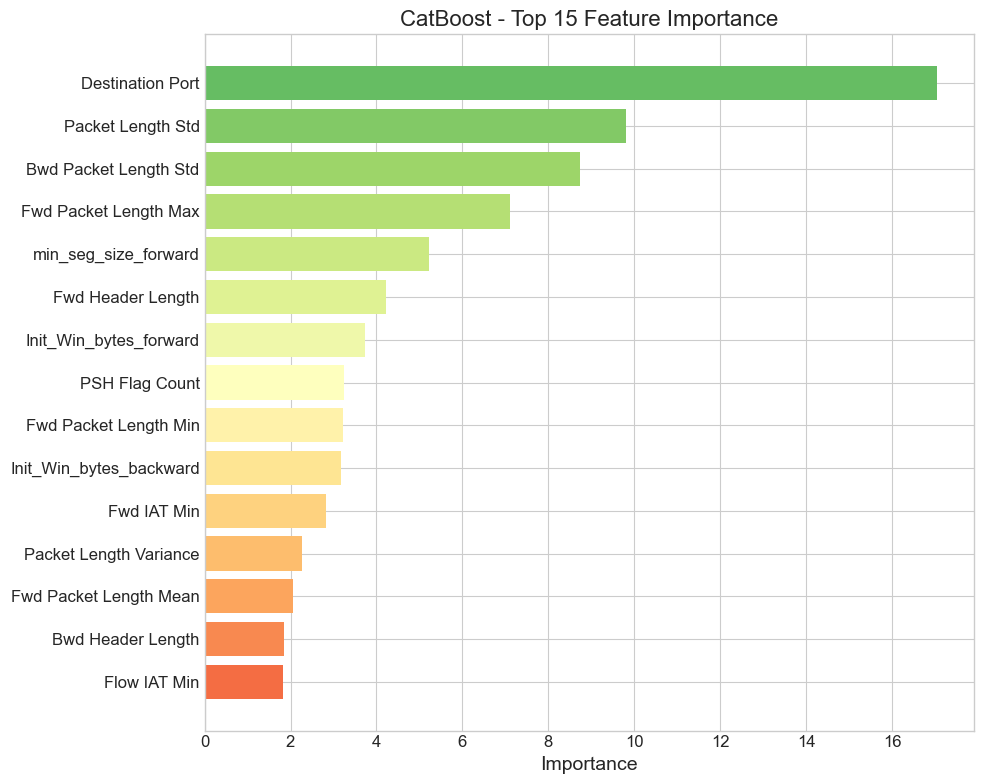

✅ Saved: catboost_feature_importance.png


In [41]:
if CatBoostClassifier is not None:
    # CatBoost Feature Importance
    catboost_importance = plot_feature_importance(catboost_model, numeric_cols,
                                                  'CatBoost', 'catboost_feature_importance.png')

---
## 11. Model 6: Isolation Forest (Anomaly Detection)

In [42]:
print("🔍 Training Isolation Forest (Anomaly Detection)...")
start = time.time()

# Train only on BENIGN samples
benign_mask = y_bin_sampled == 0
X_benign = X_scaled[benign_mask]
print(f"Training on {len(X_benign):,} BENIGN samples")

iso_model = IsolationForest(
    n_estimators=100,
    contamination=0.1,
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)
iso_model.fit(X_benign)

train_time = time.time() - start
print(f"✅ Isolation Forest trained in {train_time:.1f}s")

🔍 Training Isolation Forest (Anomaly Detection)...
Training on 240,957 BENIGN samples
✅ Isolation Forest trained in 1.9s


In [43]:
# Predict on test set (1=inlier/benign, -1=outlier/attack)
iso_predictions = iso_model.predict(X_test_bin)
iso_pred_binary = np.where(iso_predictions == 1, 0, 1)  # Convert to 0=benign, 1=attack

# Get anomaly scores
anomaly_scores = -iso_model.score_samples(X_test_bin)

# Metrics
iso_metrics = {
    'accuracy': accuracy_score(y_test_bin, iso_pred_binary),
    'precision': precision_score(y_test_bin, iso_pred_binary, zero_division=0),
    'recall': recall_score(y_test_bin, iso_pred_binary, zero_division=0),
    'f1': f1_score(y_test_bin, iso_pred_binary, zero_division=0),
    'predictions': iso_pred_binary,
    'probabilities': anomaly_scores
}
results['Isolation Forest'] = iso_metrics

print(f"\n{'='*50}")
print("ISOLATION FOREST RESULTS")
print(f"{'='*50}")
print(f"Accuracy:  {iso_metrics['accuracy']*100:.2f}%")
print(f"Precision: {iso_metrics['precision']*100:.2f}%")
print(f"Recall:    {iso_metrics['recall']*100:.2f}%")
print(f"F1-Score:  {iso_metrics['f1']*100:.2f}%")


ISOLATION FOREST RESULTS
Accuracy:  81.22%
Precision: 52.66%
Recall:    45.22%
F1-Score:  48.66%


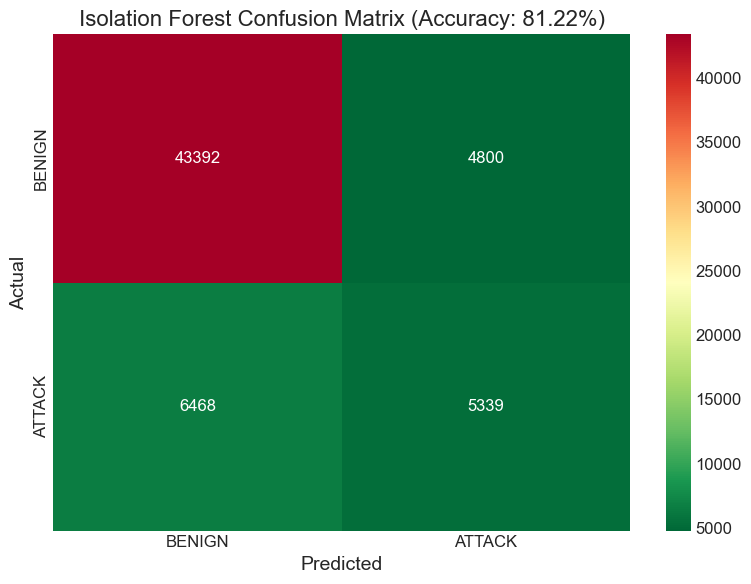

✅ Saved: iso_confusion_matrix.png


In [44]:
# Isolation Forest Confusion Matrix (Binary)
cm_iso = confusion_matrix(y_test_bin, iso_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='RdYlGn_r',
            xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Isolation Forest Confusion Matrix (Accuracy: {iso_metrics["accuracy"]*100:.2f}%)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'iso_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: iso_confusion_matrix.png")

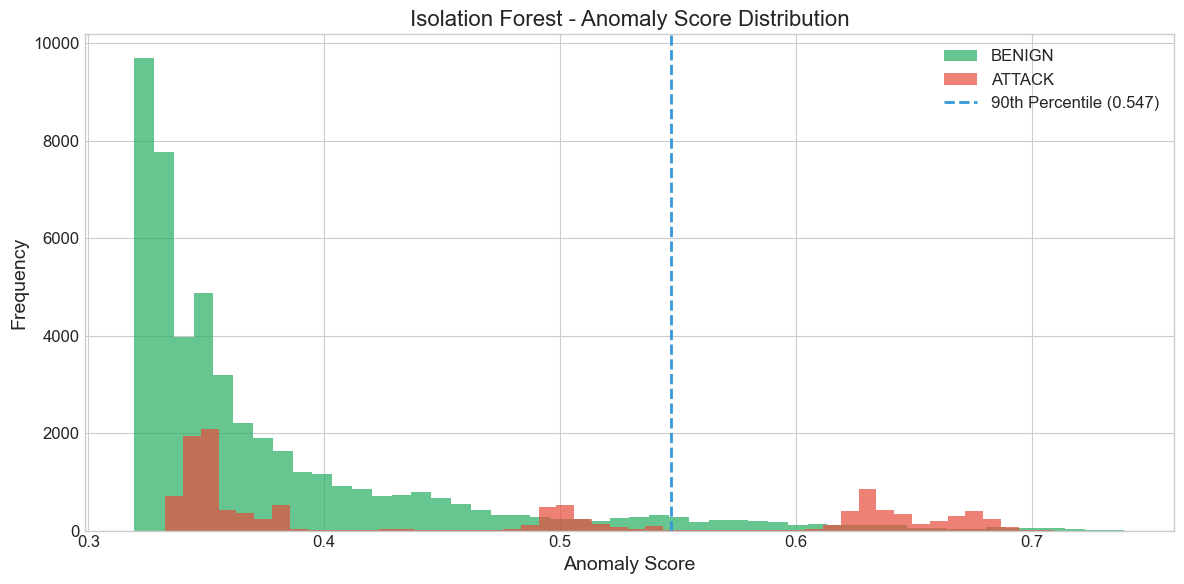

✅ Saved: iso_anomaly_scores.png


In [45]:
# Anomaly Score Distribution
plt.figure(figsize=(12, 6))
plt.hist(anomaly_scores[y_test_bin == 0], bins=50, alpha=0.7, label='BENIGN', color='#27ae60')
plt.hist(anomaly_scores[y_test_bin == 1], bins=50, alpha=0.7, label='ATTACK', color='#e74c3c')
threshold = np.percentile(anomaly_scores, 90)
plt.axvline(x=threshold, color='#3498db', linestyle='--', lw=2, label=f'90th Percentile ({threshold:.3f})')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Isolation Forest - Anomaly Score Distribution')
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'iso_anomaly_scores.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: iso_anomaly_scores.png")

---
## 12. ROC Curve Comparison (Binary Classification)

In [46]:
# Train binary versions for ROC comparison
print("Training binary classifiers for ROC comparison...")

binary_models = {}

# Random Forest Binary
rf_bin = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42)
rf_bin.fit(X_train_bin, y_train_bin)
binary_models['Random Forest'] = rf_bin

# Extra Trees Binary
et_bin = ExtraTreesClassifier(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42)
et_bin.fit(X_train_bin, y_train_bin)
binary_models['Extra Trees'] = et_bin

if XGBClassifier is not None:
    xgb_bin = XGBClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_bin.fit(X_train_bin, y_train_bin)
    binary_models['XGBoost'] = xgb_bin

if LGBMClassifier is not None:
    lgbm_bin = LGBMClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42, verbose=-1)
    lgbm_bin.fit(X_train_bin, y_train_bin)
    binary_models['LightGBM'] = lgbm_bin

if CatBoostClassifier is not None:
    cat_bin = CatBoostClassifier(iterations=100, depth=10, random_state=42, verbose=False)
    cat_bin.fit(X_train_bin, y_train_bin)
    binary_models['CatBoost'] = cat_bin

print(f"✅ Trained {len(binary_models)} binary classifiers")

Training binary classifiers for ROC comparison...
✅ Trained 5 binary classifiers


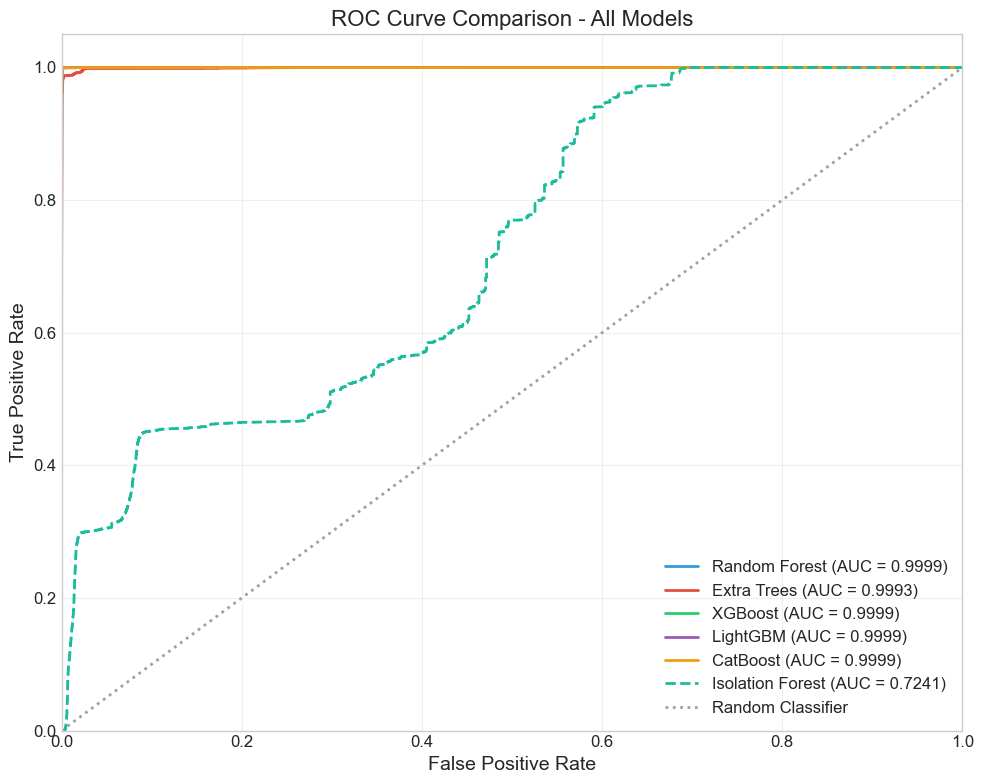

✅ Saved: roc_comparison.png


In [47]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']

for (name, model), color in zip(binary_models.items(), colors):
    y_proba = model.predict_proba(X_test_bin)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

# Isolation Forest ROC
fpr_iso, tpr_iso, _ = roc_curve(y_test_bin, anomaly_scores)
roc_auc_iso = auc(fpr_iso, tpr_iso)
plt.plot(fpr_iso, tpr_iso, color='#1abc9c', lw=2, linestyle='--', label=f'Isolation Forest (AUC = {roc_auc_iso:.4f})')

# Random baseline
plt.plot([0, 1], [0, 1], color='#95a5a6', lw=2, linestyle=':', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - All Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: roc_comparison.png")

---
## 13. Model Comparison Summary

In [48]:
# Create comparison table
comparison_data = []
for name, metrics in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': f"{metrics['accuracy']*100:.2f}%",
        'Precision': f"{metrics['precision']*100:.2f}%",
        'Recall': f"{metrics['recall']*100:.2f}%",
        'F1-Score': f"{metrics['f1']*100:.2f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("MODEL COMPARISON TABLE (FOR PAPER)")
print("="*70)
print(comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)
print(f"\n✅ Saved: model_comparison.csv")


MODEL COMPARISON TABLE (FOR PAPER)
           Model Accuracy Precision Recall F1-Score
   Random Forest   99.82%    99.80% 99.82%   99.81%
     Extra Trees   99.13%    99.11% 99.13%   99.06%
         XGBoost   99.88%    99.88% 99.88%   99.88%
        LightGBM   81.36%    89.18% 81.36%   83.67%
        CatBoost   99.81%    99.79% 99.81%   99.79%
Isolation Forest   81.22%    52.66% 45.22%   48.66%

✅ Saved: model_comparison.csv


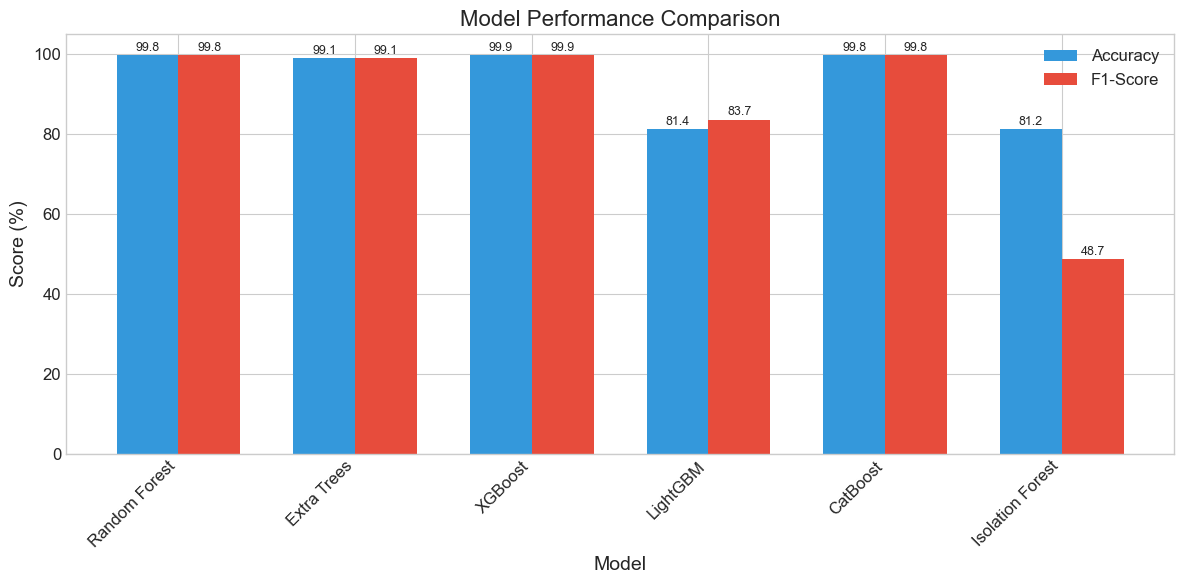

✅ Saved: model_comparison_chart.png


In [49]:
# Visualize comparison
plt.figure(figsize=(12, 6))

models = [d['Model'] for d in comparison_data]
accuracies = [float(d['Accuracy'].strip('%')) for d in comparison_data]
f1_scores = [float(d['F1-Score'].strip('%')) for d in comparison_data]

x = np.arange(len(models))
width = 0.35

bars1 = plt.bar(x - width/2, accuracies, width, label='Accuracy', color='#3498db')
bars2 = plt.bar(x + width/2, f1_scores, width, label='F1-Score', color='#e74c3c')

plt.xlabel('Model')
plt.ylabel('Score (%)')
plt.title('Model Performance Comparison')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.ylim(0, 105)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: model_comparison_chart.png")

---
## 14. Save Models

In [50]:
# Save all models
print("Saving models...")

joblib.dump(rf_model, MODEL_DIR / 'random_forest.joblib')
joblib.dump(et_model, MODEL_DIR / 'extra_trees.joblib')
if XGBClassifier is not None:
    joblib.dump(xgb_model, MODEL_DIR / 'xgboost.joblib')
if LGBMClassifier is not None:
    joblib.dump(lgbm_model, MODEL_DIR / 'lightgbm.joblib')
if CatBoostClassifier is not None:
    joblib.dump(catboost_model, MODEL_DIR / 'catboost.joblib')
joblib.dump(iso_model, MODEL_DIR / 'isolation_forest.joblib')

# Save preprocessors
joblib.dump(scaler, MODEL_DIR / 'scaler.joblib')
joblib.dump(label_encoder, MODEL_DIR / 'label_encoder.joblib')
joblib.dump(numeric_cols, MODEL_DIR / 'feature_names.joblib')

print(f"✅ All models saved to: {MODEL_DIR.absolute()}")

Saving models...
✅ All models saved to: C:\Users\Ghulam Mohayudin\Projects\Others\usod\ai\paper_results\models


---
## 15. Summary for Paper

In [51]:
print("\n" + "="*70)
print("SUMMARY FOR TECHNICAL PAPER")
print("="*70)

print(f"""
DATASET:
- Name: CICIDS2017
- Total samples: {len(data):,}
- Training samples: {len(X_train):,}
- Test samples: {len(X_test):,}
- Features: {len(numeric_cols)}
- Classes: {len(class_names)}

MODELS TRAINED:
""")

for name, metrics in results.items():
    print(f"  {name}:")
    print(f"    - Accuracy:  {metrics['accuracy']*100:.2f}%")
    print(f"    - F1-Score:  {metrics['f1']*100:.2f}%")

print(f"""
SAVED FILES:
""")
for f in OUTPUT_DIR.glob('*.png'):
    print(f"  📊 {f.name}")
for f in OUTPUT_DIR.glob('*.csv'):
    print(f"  📄 {f.name}")

print("\n✅ NOTEBOOK COMPLETE!")


SUMMARY FOR TECHNICAL PAPER

DATASET:
- Name: CICIDS2017
- Total samples: 2,827,876
- Training samples: 239,994
- Test samples: 59,999
- Features: 78
- Classes: 12

MODELS TRAINED:

  Random Forest:
    - Accuracy:  99.82%
    - F1-Score:  99.81%
  Extra Trees:
    - Accuracy:  99.13%
    - F1-Score:  99.06%
  XGBoost:
    - Accuracy:  99.88%
    - F1-Score:  99.88%
  LightGBM:
    - Accuracy:  81.36%
    - F1-Score:  83.67%
  CatBoost:
    - Accuracy:  99.81%
    - F1-Score:  99.79%
  Isolation Forest:
    - Accuracy:  81.22%
    - F1-Score:  48.66%

SAVED FILES:

  📊 catboost_confusion_matrix.png
  📊 catboost_feature_importance.png
  📊 dataset_attack_distribution.png
  📊 et_confusion_matrix.png
  📊 et_feature_importance.png
  📊 iso_anomaly_scores.png
  📊 iso_confusion_matrix.png
  📊 lgbm_confusion_matrix.png
  📊 lgbm_feature_importance.png
  📊 model_comparison_chart.png
  📊 rf_confusion_matrix.png
  📊 rf_feature_importance.png
  📊 roc_comparison.png
  📊 xgb_confusion_matrix.png
  📊 